In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [5]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [6]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [7]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g

def gradient_function(actor, critic):
    params = actor.trainable_weights
    # placeholder
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    ts_input = tf.placeholder(tf.float32, shape=(None, 1))
    values_input = tf.placeholder(tf.float32, shape=(None, 1))
    
    # q_func gradient tensor
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    obj1 = tf.multiply(K.exp(- alpha * ts_input), critic_output_tensor)
    loss1 = -K.sum(obj1)
    gradient_for_q = dummy_optimizer.get_gradients(loss1, params)
    
    # discount factor gradient tensor
    discount = tf.expand_dims(- tf.exp(- alpha * actor_output[:,1]), 1)
    weights = tf.multiply(K.exp(- alpha * ts_input), values_input) # param勾配ないならok
    obj2 = tf.multiply(weights, discount)
    loss2 = K.sum(obj2)
    gradient_for_d = dummy_optimizer.get_gradients(loss2, params)
    
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    func = K.function([state_input, ts_input, values_input], gradient_tensor)
    
    return func

def gradient(states, ts, values, gradient_func):
    gradient = gradient_func([states, ts, values])
    return gradient

# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [65]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 10)
    S2 = np.linspace(-7, 7, 10)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, batch_size = 32, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def reshape_data(data, mode=0):
    tmp = []
    for d in data:
        tmp.append(d)
    if mode==0:
        return np.array(tmp).reshape(len(data), 1, d.shape[0])
    else:
        return np.array(tmp).reshape(len(data), d.shape[0])
    
def policy_gradient2(actor, critic):
    s1 = np.linspace(-7, 7, 3)
    s2 = np.linspace(-7, 7, 3)
    S1, S2 = np.meshgrid(s1, s2)
    S1, S2 = S1.flatten(), S2.flatten()
    log = []
    nvs = []
    for i, x in enumerate(zip(S1, S2)):
        x = np.array(x)
        episode_time = 0
        episode_log = []
        while True:
            a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
            episode_log.append([x, episode_time])
            log.append([x, episode_time])
            reward, x = interaction(x, a_agent, tau, env, ln=1.)
            episode_time += tau
            if episode_time >= 30.:
                episode_log.append([x, episode_time])
                log.append([x, episode_time])
                break
        
        episode_log = np.array(episode_log)
        
        #next value
        for j in range(1,len(episode_log)):
            ns = episode_log[j][0]
            na = actor.predict_on_batch(ns.reshape(1,1,2))
            nv = critic.predict_on_batch([na, ns.reshape(1,1,2)])[0]
            nvs.append(nv)
        del log[-1]
            
    log = np.array(log)
    pg = func([reshape_data(log[:,0]), log[:,1], nvs])
    return flatten_gradient(pg)
    
    
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    # 複数状態からじゃ無理なの？
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 20.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    '''
    pg = 0
    # Q 関数の勾配を計算する
    for x, t in log:
        g = q_gradient([x], actor, critic)
        g = flatten_gradient(g)
        g *= np.exp(- alpha * t)
        pg += g
    '''
    log = np.array(log)
    nvs = []
    #next value
    for i in range(1,len(log)):
        ns = log[i][0]
        na = actor.predict_on_batch(ns.reshape(1,1,2))
        nv = critic.predict_on_batch([na, ns.reshape(1,1,2)])[0]
        nvs.append(nv)

    pg = func([reshape_data(log[:-1,0]), log[:-1,1], nvs])
    return flatten_gradient(pg)

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

def clone_model(model, target_model):
    params = get_nn_params(model)
    target_model = set_nn_params(target_model, params)
    return target_model


# 評価
def evaluation(actor):
    s1 = np.linspace(-7, 7, 3)
    s2 = np.linspace(-7, 7, 3)
    S1, S2 = np.meshgrid(s1, s2)
    S1, S2 = S1.flatten(), S2.flatten()
    average_reward = 0
    for i, x in enumerate(zip(S1, S2)):
        x = np.array(x)
        episode_time = 0
        episode_reward = 0
        log = []
        while True:
            a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
            log.append([x, episode_time])
            reward, x = interaction(x, a_agent, tau, env, ln=0.)
            episode_reward += np.exp(- alpha * episode_time) * reward
            episode_time += tau
            if episode_time >= 30.:
                log.append([x, episode_time])
                break
        average_reward += episode_reward / len(S1)
    return average_reward


In [66]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
func = gradient_function(actor, critic)

In [67]:
actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
#actor.load_weights('../saved_agent/learned_self_linear_ideal4_actor.h5')
#critic.load_weights('../saved_agent/learned_self_linear_ideal4_critic.h5')
target_actor = clone_model(actor, target_actor)
target_critic = clone_model(critic, target_critic)
lrs = learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001)
opt = Adam_original(lrs)
ev = evaluation(actor)
ev_log = [ev]
print(f'value_function for initial policy = {ev}')
for i in range(1, 100):
    d_train = train_data(actor, noise=True)
    cand, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(10000//(np.sqrt(i))))
    if np.mean(losses) > 1:
        critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)
    else:
        critic = cand
    pg = policy_gradient2(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    ev_log.append(ev)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -20.79542360755022
1-step
loss of critic is 0.014991729520261288, value_fuction V(s) = -20.21108812184971
|g| = 600429.036332177
2-step
loss of critic is 0.010295716114342213, value_fuction V(s) = -19.789795930353485
|g| = 737937.7490585488
3-step
loss of critic is 0.026713887229561806, value_fuction V(s) = -20.369029366986545
|g| = 742192.2890699
4-step
loss of critic is 0.0404663160443306, value_fuction V(s) = -19.940841217828883
|g| = 743705.0896955149
5-step
loss of critic is 0.052553050220012665, value_fuction V(s) = -19.60678473429479
|g| = 1109071.1979527872
6-step
loss of critic is 0.026553813368082047, value_fuction V(s) = -19.315856328337546
|g| = 859160.7223887038
7-step
loss of critic is 0.02010367065668106, value_fuction V(s) = -19.018927823514524
|g| = 938139.4244987706
8-step
loss of critic is 0.021780461072921753, value_fuction V(s) = -18.79097140409459
|g| = 799994.3894505978
9-step
loss of critic is 0.023481642827391624, value_fucti

KeyboardInterrupt: 

In [104]:
_, losses = td_learning(d_train, actor, critic, target_actor, target_critic, batch_size=64)

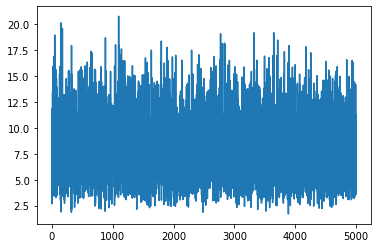

In [105]:
plt.plot(losses)

In [55]:
def branch_actor2(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

actor = branch_actor((2,),(2,))

In [76]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal4_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.load_weights('../saved_agent/learned_self_extend0_actor.h5')
# actor.load_weights('../saved_agent/mb_self_noisy_extend2_actor.h5')
initial_state = np.array([-3., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    states.append(env.state)
    episode_reward += np.exp(- alpha * acc_time) * reward
    acc_time += tau
    time_log.append(acc_time)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

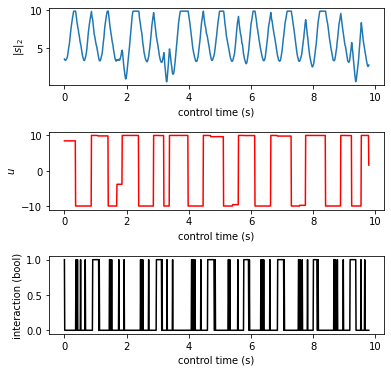

In [77]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [73]:
episode_reward

-8.096743905981755

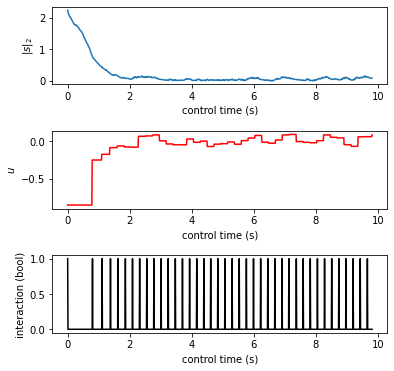

In [11]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [90]:
actor.save_weights('../saved_agent/learned_self_linear_ideal4_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_ideal4_critic.h5')

In [122]:
actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.41994604,  0.4266636 , -0.18461692,  0.16705216, -0.25361168,
        0.34438944,  0.10308936, -0.09404683, -0.1733037 , -0.22091635,
       -0.3533952 ,  0.02600434,  0.5435894 , -0.07042186, -0.3707666 ,
        0.3166266 ], dtype=float32)

In [121]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.42221597,  0.4274628 , -0.18825793,  0.16885139, -0.2542188 ,
        0.34214336,  0.10563881, -0.09488146, -0.17566861, -0.22360145,
       -0.3501546 ,  0.02824089,  0.54246134, -0.07161091, -0.37361035,
        0.31443065], dtype=float32)

In [12]:
%%time
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)

CPU times: user 4.39 s, sys: 151 ms, total: 4.54 s
Wall time: 4.97 s


In [37]:
%%time
# critic用のデータ採り
d_train = train_data(actor, noise=True)

CPU times: user 15.7 s, sys: 158 ms, total: 15.8 s
Wall time: 18.8 s


In [38]:
%%time
critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(5000//np.sqrt(12)))

CPU times: user 4.02 s, sys: 363 ms, total: 4.39 s
Wall time: 3.81 s


In [39]:
%%time
pg = policy_gradient(actor, critic)

CPU times: user 139 ms, sys: 10.1 ms, total: 149 ms
Wall time: 195 ms


In [40]:
%%time
actor = opt.update(actor, pg/np.linalg.norm(pg))

CPU times: user 27.9 ms, sys: 3.98 ms, total: 31.8 ms
Wall time: 86.1 ms


In [41]:
%%time
target_actor = update_target_model(actor, target_actor)
target_critic = update_target_model(critic, target_critic)

CPU times: user 43.2 ms, sys: 4.23 ms, total: 47.4 ms
Wall time: 66.9 ms


In [ ]:
with open('../csv/batch')

In [33]:
sr = '''
value_function for initial policy = -20.79542360755022
1-step
loss of critic is 0.016498621553182602, value_fuction V(s) = -20.183622204868136
|g| = 2883209.630423825
2-step
loss of critic is 0.010626359842717648, value_fuction V(s) = -19.727609753167645
|g| = 1501814.4586493217
3-step
loss of critic is 0.01458803378045559, value_fuction V(s) = -19.397355835242454
|g| = 2195173.364658729
4-step
loss of critic is 0.01288563571870327, value_fuction V(s) = -19.06035119698928
|g| = 1162004.5267941998
5-step
loss of critic is 0.01630791649222374, value_fuction V(s) = -18.250075471042138
|g| = 1013493.6155905991
6-step
loss of critic is 0.0178516898304224, value_fuction V(s) = -18.032255864535884
|g| = 859042.2106279823
7-step
loss of critic is 0.01681000553071499, value_fuction V(s) = -18.137709202067796
|g| = 674375.2587389589
8-step
loss of critic is 0.0197188351303339, value_fuction V(s) = -17.515516461474157
|g| = 950448.8269958217
9-step
loss of critic is 0.021432559937238693, value_fuction V(s) = -16.469204690270892
|g| = 842673.201893205
10-step
loss of critic is 0.02147667482495308, value_fuction V(s) = -16.75012091537346
|g| = 757373.227535516
11-step
loss of critic is 0.025221986696124077, value_fuction V(s) = -16.404395132126023
|g| = 985533.2882893888
12-step
loss of critic is 0.023037932813167572, value_fuction V(s) = -16.526274560541662
|g| = 714182.5874813929
13-step
loss of critic is 0.02430952712893486, value_fuction V(s) = -16.304261610147353
|g| = 677467.3984766724
14-step
loss of critic is 0.019845062866806984, value_fuction V(s) = -15.459000696218014
|g| = 692839.7255106894
15-step
loss of critic is 0.024618031457066536, value_fuction V(s) = -15.624638377101919
|g| = 661802.3437544478
16-step
loss of critic is 0.028944000601768494, value_fuction V(s) = -15.65322552284714
|g| = 584536.6692777624
17-step
loss of critic is 0.027570879086852074, value_fuction V(s) = -16.055443291045336
|g| = 959914.4367485772
18-step
loss of critic is 0.04530497267842293, value_fuction V(s) = -14.651342455144798
|g| = 473058.4636280374
19-step
loss of critic is 0.06418465822935104, value_fuction V(s) = -14.500117181660942
|g| = 715530.4888551588
20-step
loss of critic is 0.08115717023611069, value_fuction V(s) = -14.619355603421434
|g| = 839604.8831729194
21-step
loss of critic is 0.047736626118421555, value_fuction V(s) = -13.95615749194021
|g| = 421607.82128503843
22-step
loss of critic is 0.05507682263851166, value_fuction V(s) = -13.889437194902655
|g| = 653621.2334646676
23-step
loss of critic is 0.042696017771959305, value_fuction V(s) = -13.931170598124982
|g| = 594608.6972376592
24-step
loss of critic is 0.1134968176484108, value_fuction V(s) = -14.13651179189597
|g| = 920855.6022482956
25-step
loss of critic is 0.12394727766513824, value_fuction V(s) = -14.472417829600566
|g| = 1046276.1633556926
26-step
loss of critic is 0.1413934975862503, value_fuction V(s) = -14.216438816626933
|g| = 764527.2897736783
27-step
loss of critic is 0.20845820009708405, value_fuction V(s) = -14.03666192598842
|g| = 998548.8277398268
28-step
loss of critic is 0.10141348838806152, value_fuction V(s) = -14.317262190751016
|g| = 450784.0257198694
29-step
loss of critic is 0.10362929105758667, value_fuction V(s) = -13.829231049143612
|g| = 692559.8837699557
30-step
loss of critic is 0.16069740056991577, value_fuction V(s) = -13.480999617135065
|g| = 658839.0836049746
31-step
loss of critic is 0.1182079166173935, value_fuction V(s) = -13.196954243805576
|g| = 1007004.3858184818
32-step
loss of critic is 0.15903104841709137, value_fuction V(s) = -12.99034685258008
|g| = 907210.8474774576
33-step
loss of critic is 0.22325798869132996, value_fuction V(s) = -13.04276791985276
|g| = 991388.6339334355
34-step
loss of critic is 0.16388742625713348, value_fuction V(s) = -12.826764827518645
|g| = 1129326.722386913
35-step
loss of critic is 0.21613827347755432, value_fuction V(s) = -12.411378282152345
|g| = 944410.656080985
36-step
loss of critic is 0.1591460406780243, value_fuction V(s) = -12.281014058093643
|g| = 1112568.8289936953
37-step
loss of critic is 0.16690877079963684, value_fuction V(s) = -12.058641184438647
|g| = 714859.7858056272
38-step
loss of critic is 0.20537611842155457, value_fuction V(s) = -11.958817988909468
|g| = 1346722.724280854
39-step
loss of critic is 0.247748002409935, value_fuction V(s) = -11.950755160136746
|g| = 1187157.9057923004
40-step
loss of critic is 0.2136133313179016, value_fuction V(s) = -11.532735962153872
|g| = 998276.5508064927
41-step
loss of critic is 0.21615681052207947, value_fuction V(s) = -11.738604586542909
|g| = 867306.6473182307
42-step
loss of critic is 0.2506321966648102, value_fuction V(s) = -11.901290346081797
|g| = 971096.9260590854
43-step
loss of critic is 0.24946561455726624, value_fuction V(s) = -11.360395598420201
|g| = 813188.4642892522
44-step
loss of critic is 0.2679173946380615, value_fuction V(s) = -11.303197103311259
|g| = 983767.2069822995
45-step
loss of critic is 0.33091044425964355, value_fuction V(s) = -11.391128966596794
|g| = 1102789.1488991054
46-step
loss of critic is 0.2906932532787323, value_fuction V(s) = -11.738291769718957
|g| = 983738.0501966816
47-step
loss of critic is 0.2964433431625366, value_fuction V(s) = -12.705904236930712
|g| = 1433071.5751418744
48-step
loss of critic is 0.2362993061542511, value_fuction V(s) = -14.490582983030624
|g| = 1678354.1044051594
49-step
loss of critic is 0.267484188079834, value_fuction V(s) = -14.480391753742897
|g| = 1659945.6841905715
50-step
loss of critic is 0.34569141268730164, value_fuction V(s) = -14.370297112713423
|g| = 1284611.6627794914
51-step
loss of critic is 0.3148527443408966, value_fuction V(s) = -14.00640431691007
|g| = 1435098.4300103409
52-step
loss of critic is 0.20993922650814056, value_fuction V(s) = -11.70905030960466
|g| = 1421458.7527274615
53-step
loss of critic is 0.26039189100265503, value_fuction V(s) = -11.310380418448036
|g| = 950517.3174692461
54-step
loss of critic is 0.32416531443595886, value_fuction V(s) = -11.055752189982723
|g| = 1205155.9231619977
55-step
loss of critic is 0.20816335082054138, value_fuction V(s) = -10.866956296901863
|g| = 1035023.2648925639
56-step
loss of critic is 0.17631667852401733, value_fuction V(s) = -10.790833143911668
|g| = 821786.9111596815
57-step
loss of critic is 0.2525973618030548, value_fuction V(s) = -10.747684971526851
|g| = 639678.4647090875
58-step
loss of critic is 0.2319626659154892, value_fuction V(s) = -10.69419884856781
|g| = 881477.3048395937
59-step
loss of critic is 0.263446182012558, value_fuction V(s) = -10.73089727182161
|g| = 697843.133581457
60-step
loss of critic is 0.27609390020370483, value_fuction V(s) = -10.692259628066774
|g| = 703769.0701536465
61-step
loss of critic is 0.2519197165966034, value_fuction V(s) = -10.738313792985924
|g| = 1023794.3327987917
62-step
loss of critic is 0.2601413130760193, value_fuction V(s) = -10.70871174357654
|g| = 818241.3240727455
63-step
loss of critic is 0.2201148271560669, value_fuction V(s) = -10.657746512841555
|g| = 909506.2146514027
64-step
loss of critic is 0.30479884147644043, value_fuction V(s) = -10.594853359546258
|g| = 719349.0902986453
65-step
loss of critic is 0.2131134569644928, value_fuction V(s) = -10.546417256578806
|g| = 551136.4619971785
66-step
loss of critic is 0.22529684007167816, value_fuction V(s) = -10.562864973464112
|g| = 556367.422982191
67-step
loss of critic is 0.1966206431388855, value_fuction V(s) = -10.52181129323763
|g| = 614198.1752493578
68-step
loss of critic is 0.22954140603542328, value_fuction V(s) = -10.430597059984036
|g| = 813746.2175283979
69-step
loss of critic is 0.3350330889225006, value_fuction V(s) = -10.403550562042682
|g| = 644079.6375873139
70-step
loss of critic is 0.44829457998275757, value_fuction V(s) = -10.328857470599427
|g| = 556603.5419438173
71-step
loss of critic is 0.2559346556663513, value_fuction V(s) = -10.271799676390557
|g| = 500168.6262505726
72-step
loss of critic is 0.2926323711872101, value_fuction V(s) = -10.17467765757093
|g| = 624231.2040085787
73-step
loss of critic is 0.2738981246948242, value_fuction V(s) = -10.178992912822594
|g| = 468817.9703435496
74-step
loss of critic is 0.3690643906593323, value_fuction V(s) = -10.172542985606098
|g| = 716280.9957558219
75-step
loss of critic is 0.29776716232299805, value_fuction V(s) = -10.044807794955084
|g| = 544661.1589117041
76-step
loss of critic is 0.3657636344432831, value_fuction V(s) = -10.019743619172441
|g| = 383688.34789992543
77-step
loss of critic is 0.416746586561203, value_fuction V(s) = -9.965312052553067
|g| = 515170.2015091055
78-step
loss of critic is 0.3523375391960144, value_fuction V(s) = -9.878190706480416
|g| = 471632.57347760914
79-step
loss of critic is 0.423318088054657, value_fuction V(s) = -9.940157219224211
|g| = 648534.3551246015
80-step
loss of critic is 0.4063098430633545, value_fuction V(s) = -10.069502692762867
|g| = 932404.1180735467
81-step
loss of critic is 0.48610177636146545, value_fuction V(s) = -10.028998218884036
|g| = 360692.53620038595
82-step
loss of critic is 0.5860991477966309, value_fuction V(s) = -10.242226685311525
|g| = 493463.6051059393
83-step
loss of critic is 0.4954622685909271, value_fuction V(s) = -10.172986307276162
|g| = 424461.4914918888
84-step
loss of critic is 0.37090831995010376, value_fuction V(s) = -10.184491594610975
|g| = 555382.7775738909
85-step
loss of critic is 0.6517215967178345, value_fuction V(s) = -10.129720407986111
|g| = 550798.2190038469
86-step
loss of critic is 0.4772835969924927, value_fuction V(s) = -10.367465963545282
|g| = 619109.5307167749
87-step
loss of critic is 0.81122887134552, value_fuction V(s) = -10.254827240394668
|g| = 383143.2298719785
88-step
loss of critic is 0.6491813659667969, value_fuction V(s) = -9.610489842830894
|g| = 299117.44004069426
89-step
loss of critic is 0.47995197772979736, value_fuction V(s) = -9.71689086477463
|g| = 752030.3606031357
90-step
loss of critic is 0.6690222024917603, value_fuction V(s) = -9.816714153791093
|g| = 930995.3370436643
91-step
loss of critic is 0.7868018746376038, value_fuction V(s) = -9.549571669670664
|g| = 581102.5117827376
92-step
loss of critic is 0.6514777541160583, value_fuction V(s) = -9.4604624554222
|g| = 569578.1927966225
93-step
loss of critic is 0.6704739332199097, value_fuction V(s) = -9.415109044756758
|g| = 384190.80613368005
94-step
loss of critic is 0.5926306247711182, value_fuction V(s) = -9.335455454924572
|g| = 649688.0734850508
95-step
loss of critic is 0.7929472327232361, value_fuction V(s) = -9.258398538572536
|g| = 318367.75128577737
96-step
loss of critic is 0.6830520033836365, value_fuction V(s) = -9.220954858162226
|g| = 793799.5000849558
97-step
loss of critic is 0.6281853914260864, value_fuction V(s) = -9.167055533998397
|g| = 860735.9171625823
98-step
loss of critic is 0.7831553816795349, value_fuction V(s) = -9.661963930128893
|g| = 527917.6421045567
99-step
loss of critic is 0.6632065773010254, value_fuction V(s) = -10.113714079366034
|g| = 486717.7948111184
'''

In [34]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

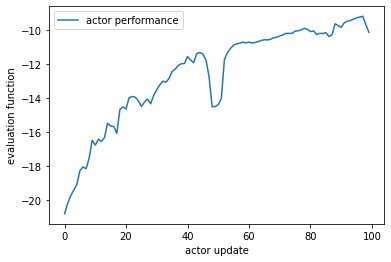

In [36]:
#rs = rs[15:]
m = 5
plt.plot(rs, label='actor performance')
#plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('evaluation function')
plt.legend()

In [ ]:
with open('')